
Call:
lm(formula = y ~ x, data = data_linear)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.620  -6.943  -0.079   6.923  33.085 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 30.95279    0.66357   46.65   <2e-16 ***
x            2.98338    0.01145  260.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.25 on 998 degrees of freedom
Multiple R-squared:  0.9855,	Adjusted R-squared:  0.9855 
F-statistic: 6.785e+04 on 1 and 998 DF,  p-value: < 2.2e-16


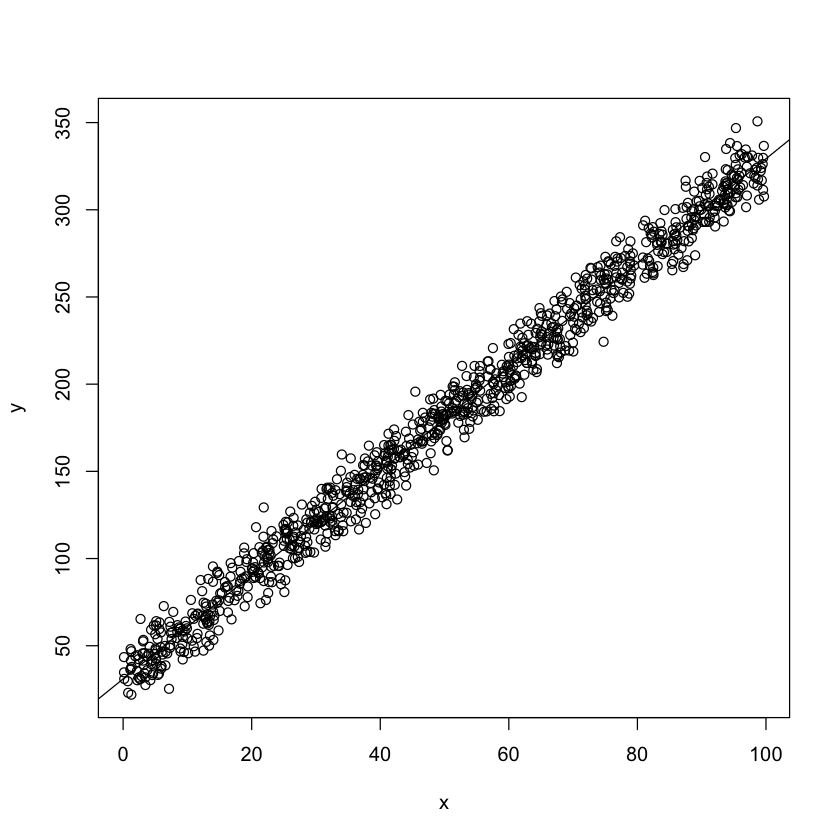

In [69]:
x <- runif(1000, 0, 100)
y <- x*3 + rnorm(1000, 0, 10)+30
data_linear <- data.frame(x = x, y = y)
plot(data_linear)
abline(lm(y ~x, data = data_linear))
summary(lm(y ~x, data = data_linear))

In [81]:
get_likelihood <- function(data, par){
    fit_y <- data$x*par[1] + par[2]
    return(log(1/mean((fit_y - y)^2)))
}

get_prior <- function(par){
    log(dnorm(par[1], mean = 3, sd = 10))+log(dnorm(par[2], mean = 30, sd = 10))
}

In [91]:
nsamp = 100000
out_frame <- data.frame(step = 1:nsamp, likelihood = rep(NA, nsamp), 
                       prior = rep(NA, nsamp), posterior = rep(NA, nsamp), 
                       slope = rep(NA, nsamp), intercept = rep(NA, nsamp))

In [92]:
#initialise states
lik1 <- get_likelihood(data_linear, c(0, 0))
prior1 <- get_prior(c(0, 0))
out_frame[1,2:ncol(out_frame) ] <- c(lik1, prior1, lik1+prior1, 0, 0)

In [93]:
total_accept <- 0
total_reject <- 0
for(i in 2:nsamp){
    p1 <- as.numeric(out_frame[i-1, 5] + rnorm(1, mean = 0, sd =0.5))
    p2 <- as.numeric(out_frame[i-1, 6]) + rnorm(1, mean = 0, sd = 0.5)
    params_proposed <- c(p1, p2)
    lik_proposal <- get_likelihood(data_linear, params_proposed)
    prior_proposal <- get_prior(params_proposed)
    posterior_proposal <- lik_proposal+prior_proposal
    
    if(posterior_proposal>=out_frame[i-1, 4]){
        out_frame[i, 2:ncol(out_frame)] <- c(lik_proposal, prior_proposal, 
                                             posterior_proposal, params_proposed)
        total_accept <- total_accept+1
    }else{
        mh_ratio <- exp(posterior_proposal - out_frame[i-1, 4])
        if(mh_ratio> runif(1)){
            total_accept <- total_accept+1
            out_frame[i, 2:ncol(out_frame)] <- c(lik_proposal, prior_proposal, 
                                             posterior_proposal, params_proposed)
        }else{
            total_reject <- total_reject+1
            out_frame[i, 2:ncol(out_frame)] <- out_frame[i-1, 2:ncol(out_frame)]
        }
    }
}

In [94]:
mh_ratio

[1] 0.05688238

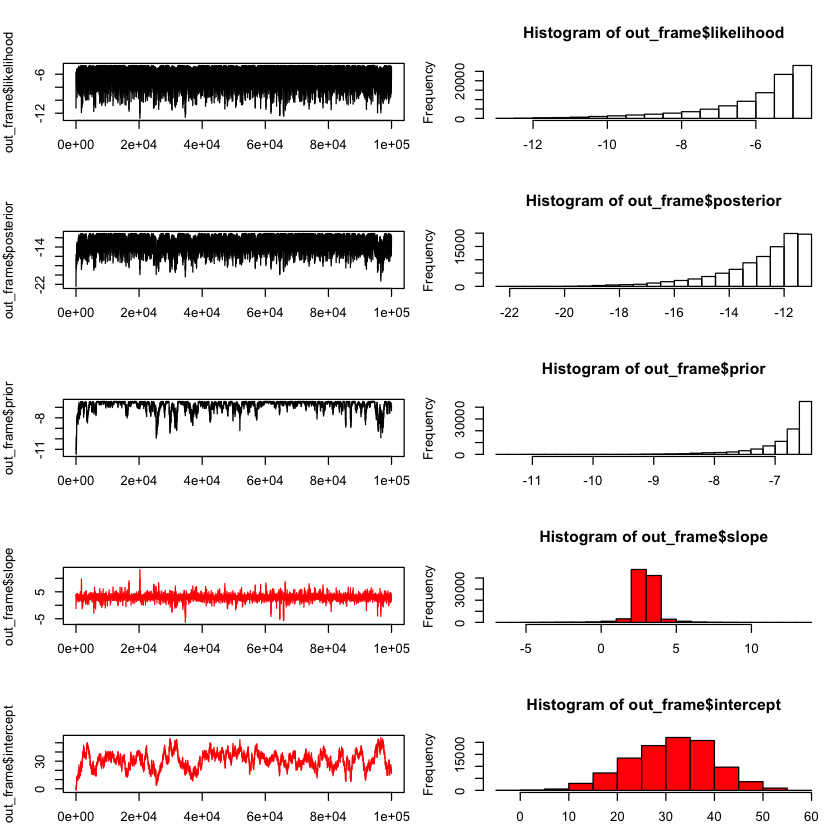

In [95]:
par(mfcol = c(5, 2))
par(mar = c(3, 4, 4, 1))
plot(out_frame$likelihood, type = 'l')
plot(out_frame$posterior, type = 'l')
plot(out_frame$prior, type = 'l')
plot(out_frame$slope, type = 'l', col = 'red')
plot(out_frame$intercept, type = 'l', col = 'red')

hist(out_frame$likelihood)
hist(out_frame$posterior)
hist(out_frame$prior)
hist(out_frame$slope, col = 'red')
hist(out_frame$intercept, col = 'red')

In [96]:
total_accept

[1] 54923

In [97]:
total_reject

[1] 45076

In [98]:
colMeans(out_frame)

step   likelihood        prior    posterior        slope    intercept 
50000.500000    -5.993663    -6.824294   -12.817957     2.952284    31.064179

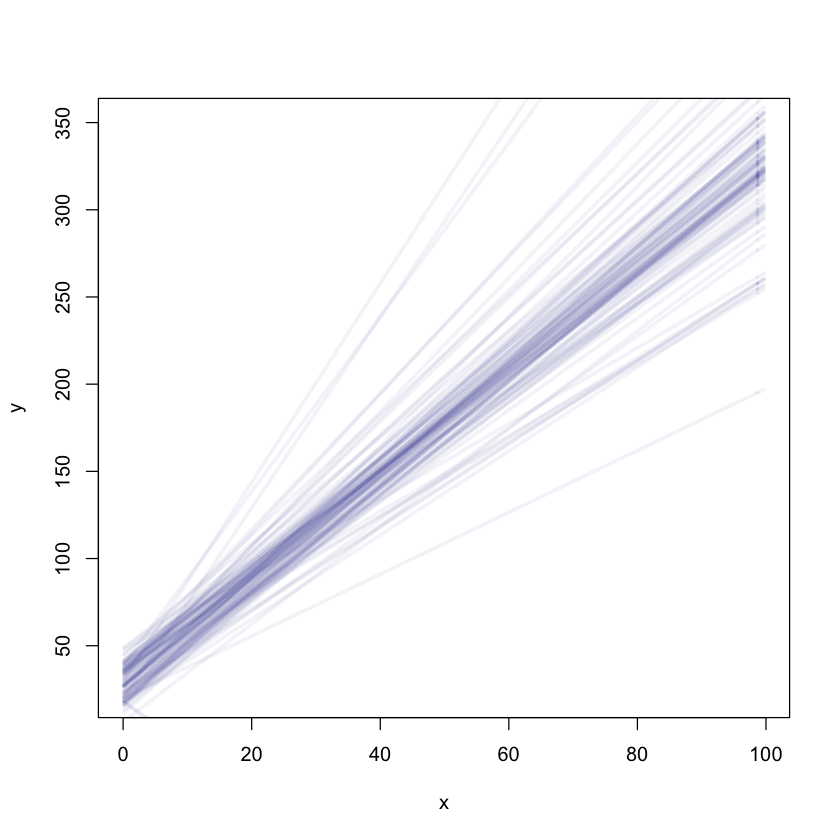

In [100]:
plot(data_linear, type = 'n')
for(f in 1:100){
    samp <- sample(200:10000, 1)
    fun <- function(x) (x*out_frame[samp, 5]) + out_frame[samp, 6]
    curve(fun, add = T, lwd = 3, col = rgb(0, 0, 0.5, 0.05))
}